# <center>+++ Project still in progres +++<center>

# Sentiment Analysis on Twitter Data

## 1. Data Cleaning

In [31]:
# general
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image
from collections import Counter

# nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [36]:
%%time
columns = ['target', 'id', 'date', 'query_string', 'user', 'text']
df = pd.read_csv('trainingdata.csv', header=None, names=columns, encoding='latin1')
df = df[['target', 'text']]

Wall time: 8.93 s


In [3]:
df.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [4]:
df.groupby(['target']).count()

,text
target,
0,800000
4,800000


In [5]:
decode_map = {0: 'negative', 2: 'neutral', 4: 'positive'}
def decode_sentiment(label):
    return decode_map[int(label)]

In [6]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

Wall time: 745 ms


Text(0.5, 1.0, 'Dataset labels distribution')

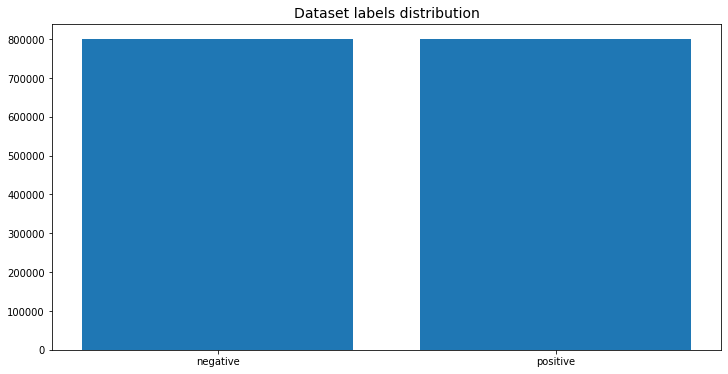

In [7]:
target_cnt = Counter(df.target)

plt.figure(figsize=(12,6))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title('Dataset labels distribution', fontsize=14)

In [8]:
%%time
cvec = CountVectorizer()
cvec.fit(df.text)

Wall time: 34.9 s


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [9]:
print(cvec.get_feature_names())

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [10]:
%%time

#Create matrices with word counts for neg and pos texts
neg_doc_matrix = cvec.transform(df[df.target == 'negative'].text)
pos_doc_matrix = cvec.transform(df[df.target == 'positive'].text)

#Create 2 lists with counts for each word in all neg and pos texts
neg_tf = np.sum(neg_doc_matrix, axis=0)
pos_tf = np.sum(pos_doc_matrix, axis=0)

#Convert neg and pos word count lists from from dim (1, 684358) to dim (684358,)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))

#Combine two arrays from neg and pos word counts to dataframe and add words as headers
term_freq_df = pd.DataFrame([neg,pos], columns=cvec.get_feature_names()).transpose()
print(term_freq_df.shape)
print(term_freq_df.iloc[89700:89720,:])

term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']

term_freq_df.sort_values(by='total', ascending=False).iloc[0:10]

(684358, 2)
                    0    1
backstagejbj        2    3
backstagepazz       0    1
backstard           0    1
backstop            0    1
backstory           5   15
backstothewall      2    0
backstreeets        0    1
backstreet         20   48
backstreet_team     3    6
backstreetbb21      0    1
backstreetboy       0    1
backstreetboys    131  139
backstreetlover     0    1
backstreetpride     0    1
backstreets         1    1
backstreetsmac      0    1
backstret           1    0
backstroke          3    0
backstrom           1    0
backststreetboys    1    0
Wall time: 1min 43s


,negative,positive,total
to,313176,252704,565880
the,257869,266003,523872
my,190846,125983,316829
it,157225,147544,304769
and,153968,149635,303603
you,103842,198194,302036
is,128452,109876,238328
in,115445,101115,216560
for,98986,117362,216348
of,92717,91087,183804


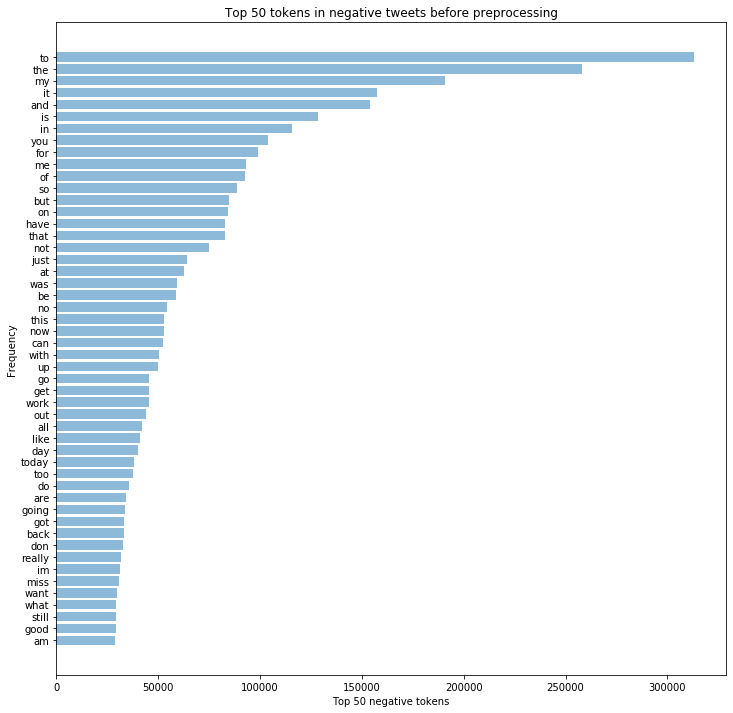

In [11]:
y_pos = np.arange(50)
plt.figure(figsize=(12,12))
plt.barh(y_pos, term_freq_df.sort_values(by='negative', ascending=False)['negative'][:50], align='center', alpha=0.5)
plt.yticks(y_pos, term_freq_df.sort_values(by='negative', ascending=False)['negative'][:50].index, rotation='horizontal')
plt.ylabel('Frequency')
plt.xlabel('Top 50 negative tokens')
plt.title('Top 50 tokens in negative tweets before preprocessing')
plt.gca().invert_yaxis()

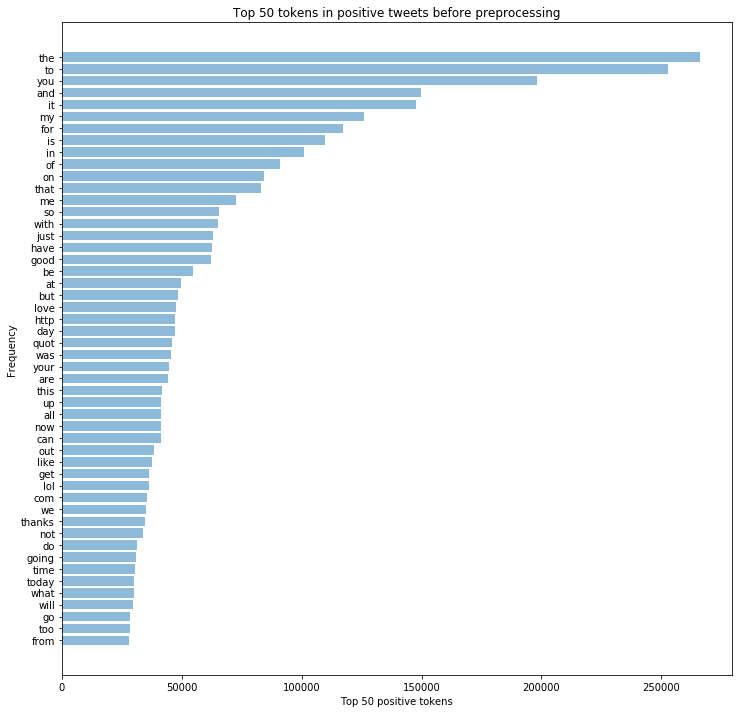

In [12]:
y_pos = np.arange(50)
plt.figure(figsize=(12,12))
plt.barh(y_pos, term_freq_df.sort_values(by='positive', ascending=False)['positive'][:50], align='center', alpha=0.5)
plt.yticks(y_pos, term_freq_df.sort_values(by='positive', ascending=False)['positive'][:50].index, rotation='horizontal')
plt.ylabel('Frequency')
plt.xlabel('Top 50 positive tokens')
plt.title('Top 50 tokens in positive tweets before preprocessing')
plt.gca().invert_yaxis()

In [13]:
corpus = ['This is the first document.','This document is the second document.','And this is the third one.', 'Is this the first document?']
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names())
print(X.toarray())

['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']
[[0 1 1 1 0 0 1 0 1]
 [0 2 0 1 0 1 1 0 1]
 [1 0 0 1 1 0 1 1 1]
 [0 1 1 1 0 0 1 0 1]]


In [14]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [32]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    #for tweet in textdata:
        #tweet = tweet.lower()
    tweet = textdata.lower()
    # Replace all URls with 'URL'
    tweet = re.sub(urlPattern,' URL',tweet)
    # Replace all emojis.
    for emoji in emojis.keys():
        tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
    # Replace @USERNAME to 'USER'.
    tweet = re.sub(userPattern,' USER', tweet)        
    # Replace all non alphabets.
    tweet = re.sub(alphaPattern, " ", tweet)
    # Replace 3 or more consecutive letters by 2 letter.
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

    tweetwords = ''
    for word in tweet.split():
        # Checking if the word is a stopword.
        if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        # processedText.append(tweetwords)
        
    return tweetwords

In [37]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

Wall time: 7min 8s


In [38]:
X_train, X_test, y_train, y_test = train_test_split(df[['text']], df[['target']], test_size = 0.2, random_state = 0)
df.head()

,target,text
0,0,USER URL aww bummer shoulda got david carr thi...
1,0,upset update facebook texting might cry result...
2,0,USER dived many time ball managed save 50 rest...
3,0,whole body feel itchy like fire
4,0,USER no not behaving mad see over


In [40]:
X_train.head()

,text
1519669,USER thx like ur pic well
1245284,URL wore better USER USER
1299040,get work yet thinking must switch garage excit...
200654,USER hmm not sure know fill ticket complete n00b
699963,USER sorry lot peaceful healing vibe


In [41]:
%%time
vectorizer_prep = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectorizer_prep.fit(X_train)
print('No. of feature_words: ', len(vectorizer_prep.get_feature_names()))
print(vectorizer_prep)

No. of feature_words:  1
TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0,
                max_features=500000, min_df=1, ngram_range=(1, 2), norm='l2',
                preprocessor=None, smooth_idf=True, stop_words=None,
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)
Wall time: 6 ms


In [ ]:
%%time

#Create matrices with word counts for neg and pos texts
neg_doc_matrix_prep = cvec_prep.transform(df_prep[df_prep.target == 'negative'].text)
pos_doc_matrix_prep = cvec_prep.transform(df_prep[df_prep.target == 'positive'].text)

#Create 2 lists with counts for each word in all neg and pos texts
neg_tf_prep = np.sum(neg_doc_matrix_prep, axis=0)
pos_tf_prep = np.sum(pos_doc_matrix_prep, axis=0)

#Convert neg and pos word count lists from from dim (1, 684358) to dim (684358,)
neg_prep = np.squeeze(np.asarray(neg_tf_prep))
pos_prep = np.squeeze(np.asarray(pos_tf_prep))

#Combine two arrays from neg and pos word counts to dataframe and add words as headers
term_freq_df_prep = pd.DataFrame([neg_prep,pos_prep], columns=cvec_prep.get_feature_names()).transpose()
print(term_freq_df_prep.shape)
print(term_freq_df_prep.iloc[89700:89720,:])

term_freq_df_prep.columns = ['negative', 'positive']
term_freq_df_prep['total'] = term_freq_df_prep['negative'] + term_freq_df_prep['positive']

term_freq_df_prep.sort_values(by='total', ascending=False).iloc[0:10]

In [ ]:
x_range = np.arange(50)
plt.figure(figsize=(12,12))
plt.barh(x_range, term_freq_df_prep.sort_values(by='negative', ascending=False)['negative'][:50], align='center', alpha=0.5)
plt.yticks(x_range, term_freq_df_prep.sort_values(by='negative', ascending=False)['negative'][:50].index, rotation='horizontal')
plt.xlabel('Frequency')
plt.ylabel('Top 50 negative tokens')
plt.title('Top 50 tokens in negative tweets after preprocessing')
plt.gca().invert_yaxis()

In [ ]:
x_range = np.arange(50)
plt.figure(figsize=(12,12))
plt.barh(x_range, term_freq_df_prep.sort_values(by='positive', ascending=False)['positive'][:50], align='center', alpha=0.5)
plt.yticks(x_range, term_freq_df_prep.sort_values(by='positive', ascending=False)['positive'][:50].index, rotation='horizontal')
plt.xlabel('Frequency')
plt.ylabel('Top 50 positive tokens')
plt.title('Top 50 tokens in positive tweets after preprocessing')
plt.gca().invert_yaxis()

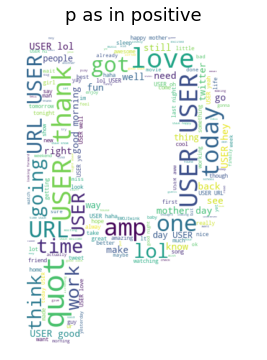

In [46]:
mask = np.array(Image.open('positive.PNG'))
plt.figure(figsize=(12, 6))
wc = WordCloud(mask=mask, background_color='white', max_words=2000, width=mask.shape[1], height=mask.shape[0]).generate(' '.join(df[df['target']==4].iloc[0:200000].text))
plt.axis('off')
plt.title('p as in positive', fontsize=18)
plt.imshow(wc, interpolation='bilinear');

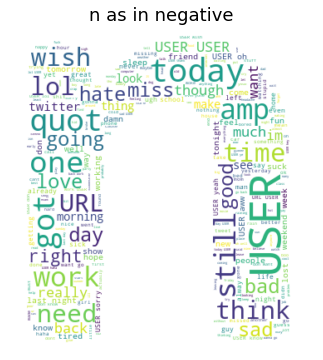

In [48]:
mask = np.array(Image.open('negative.PNG'))
plt.figure(figsize=(12, 6))
wc = WordCloud(mask=mask, background_color='white', max_words=2000, width=mask.shape[1], height=mask.shape[0]).generate(' '.join(df[df['target']==0].iloc[0:200000].text))
plt.axis('off')
plt.title('n as in negative', fontsize=18)
plt.imshow(wc, interpolation='bilinear');

## 2. Modelling and Prediction

In [ ]:
test_size = 0.2
max_nb_words = 100000
max_sequence_length = 30

In [ ]:
df_model = df_prep[['target', 'text']]
train_data, test_data = train_test_split(df_model, test_size=test_size, random_state=7)
print('Train data size: {}'.format(len(train_data)))
print('Test data size: {}'.format(len(test_data)))

In [ ]:
train_data.head()